✅ Libraries imported.
Please upload your 'superstore_final_dataset' file:


Saving superstore_final_dataset (1).csv to superstore_final_dataset (1) (1).csv
✅ File 'superstore_final_dataset (1) (1).csv' uploaded successfully.
✅ Data loaded successfully. Shape: (9800, 18)
Postal_Code missing: 11 rows. Filling with 'Unknown'.
CRITICAL: Found 5841 rows with missing Order_Date. These rows will be dropped.
New shape after dropping: (3959, 18)
✅ Initial parsing and cleaning complete.

--- Lead Time Stats (Before Imputation) ---


,lead_time_days
count,2676.000000
mean,107.010837
std,54.264484
min,0.000000
25%,61.000000
50%,122.000000
75%,153.000000
max,214.000000


Filled 1283 missing lead times with median value (122.0 days).

--- Handling Sales Outliers ---
Top 15 Sales (Checking for 'Hero Products' vs 'Errors'):


,Order_ID,Product_Name,Category,Sales
6826,CA-2017-118689,Canon imageCLASS 2200 Advanced Copier,Technology,17499.950
8488,CA-2017-158841,HP Designjet T520 Inkjet Large Format Printer ...,Technology,8749.950
165,CA-2015-139892,Lexmark MX611dhe Monochrome Laser Printer,Technology,8159.952
683,US-2018-168116,Cubify CubeX 3D Printer Triple Head Print,Technology,7999.980
7666,US-2017-140158,Hewlett Packard LaserJet 3310 Copier,Technology,5399.910
6340,CA-2018-143112,"3D Systems Cube Printer, 2nd Generation, Magenta",Technology,5199.960
1085,US-2017-143819,Ativa V4110MDD Micro-Cut Shredder,Technology,4899.930
4218,CA-2018-149881,Cubify CubeX 3D Printer Double Head Print,Technology,4799.984
8204,CA-2016-114811,Zebra ZM400 Thermal Label Printer,Technology,4643.800
9741,CA-2016-117086,"Riverside Palais Royal Lawyers Bookcase, Royal...",Furniture,4404.900


Sales values capped at 99th percentile (2,194.80)
Sales mean (Original):   220.35
Sales mean (Winsorized): 201.16
Sales median (Original): 55.36

--- KPI Analysis (Based on Winsorized Sales) ---
🏆 Top Month (Winsorized Sales):


,Sales_winsor
YearMonth,
2018-02,35826.3626



🏆 Top 10 Products (Winsorized Sales):


,Sales_winsor
Product_Name,
"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",8148.9320
GBC DocuBind TL300 Electric Binding System,8025.2392
"Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish",5887.2744
Tennsco 6- and 18-Compartment Lockers,5674.6380
Global Deluxe High-Back Managers Chair,5569.3682
Wilson Electronics DB Pro Signal Booster,5298.4000
GuestStacker Chair with Chrome Finish Legs,5094.5322
Adjustable Depth Letter/Legal Cart,5008.2960
Hewlett Packard LaserJet 3310 Copier,4954.7582



🏆 Revenue by Region (Winsorized Sales):


,Sales_winsor
Region,
West,259103.4337
East,223744.4696
Central,183350.5416
South,130185.5071



--- Visualizing Sales Distribution ---


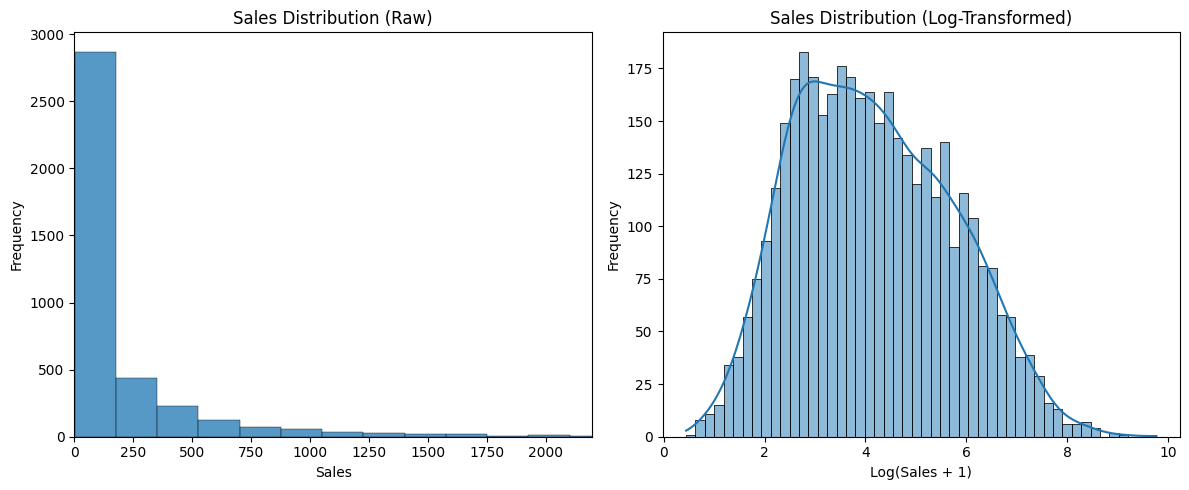

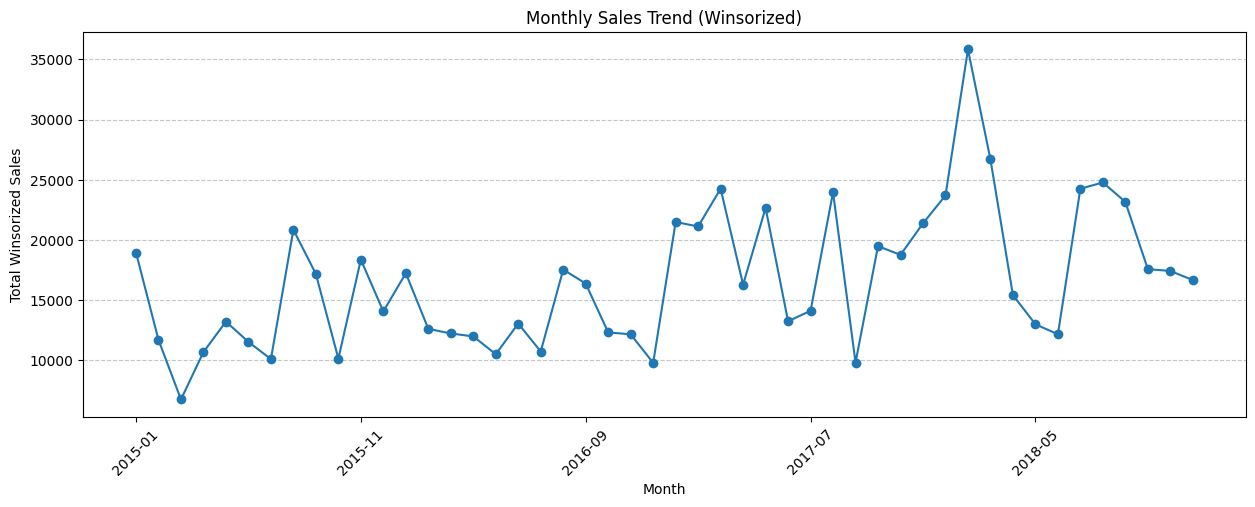


✅ CLEANING COMPLETE. Final dataset saved to: /content/superstore_cleaned_final.csv


In [ ]:
# ---------- 1. IMPORTS ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Libraries imported.")

# ---------- 2. LOAD DATA (Interactive Upload) ----------
from google.colab import files

print("Please upload your 'superstore_final_dataset' file:")
# This will show an upload button
uploaded = files.upload()

# Get the name of the file that was *actually* uploaded
file_name = list(uploaded.keys())[0]
print(f"✅ File '{file_name}' uploaded successfully.")

# Now, read the file using the 'file_name' variable
try:
    df = pd.read_csv(file_name, encoding='latin1', low_memory=False)
    print(f"✅ Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    print(f"❌ ERROR reading the CSV file: {e}")

# ---------- 3. INITIAL CLEANING & PARSING ----------

# Parse date columns
# 'errors=coerce' will turn unreadable dates into 'NaT' (Not a Time)
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], errors='coerce')

# Handle Missing Postal_Code
# Fill with 'Unknown' (safer for categorical analysis than 0)
postal_missing_count = df['Postal_Code'].isna().sum()
print(f"Postal_Code missing: {postal_missing_count} rows. Filling with 'Unknown'.")
df['Postal_Code'] = df['Postal_Code'].fillna('Unknown')

# CRITICAL STEP: Handle Missing Order_Date
# Rows without an Order_Date are unusable for time-series analysis
order_date_missing = df['Order_Date'].isna().sum()
if order_date_missing > 0:
    print(f"CRITICAL: Found {order_date_missing} rows with missing Order_Date. These rows will be dropped.")
    df = df.dropna(subset=['Order_Date'])
    print(f"New shape after dropping: {df.shape}")

print("✅ Initial parsing and cleaning complete.")

# ---------- 4. FEATURE ENGINEERING: LEAD TIME ----------

# Create lead_time_days (Shipping duration)
df['lead_time_days'] = (df['Ship_Date'] - df['Order_Date']).dt.days

# Check stats (will show 'NaN' for missing Ship_Date)
print("\n--- Lead Time Stats (Before Imputation) ---")
display(df['lead_time_days'].describe())

# Impute missing lead_time_days (where Ship_Date was NaT)
# We fill with the median lag, as it's robust to outliers
median_lag = df['lead_time_days'].median()
df['lead_time_days_filled'] = df['lead_time_days'].fillna(median_lag)
print(f"Filled {df['lead_time_days'].isna().sum()} missing lead times with median value ({median_lag} days).")

# ---------- 5. HANDLE OUTLIERS: SALES ----------
print("\n--- Handling Sales Outliers ---")

# Show top 15 sales to verify they are real products (Hero Products)
print("Top 15 Sales (Checking for 'Hero Products' vs 'Errors'):")
display(df.sort_values('Sales', ascending=False).head(15)[['Order_ID','Product_Name','Category','Sales']])

# A) Winsorize Sales: Cap extreme values for reliable KPIs
# We cap the top 1% of sales to reduce outlier impact on sums/means
upper_pct_99 = df['Sales'].quantile(0.99)
df['Sales_winsor'] = df['Sales'].clip(upper=upper_pct_99)
print(f"Sales values capped at 99th percentile ({upper_pct_99:,.2f})")

# B) Log Transform Sales: For visualization and modeling
# Use log1p to handle zero values
df['Sales_log'] = np.log1p(df['Sales'])

# Compare stats
print(f"Sales mean (Original):   {df['Sales'].mean():,.2f}")
print(f"Sales mean (Winsorized): {df['Sales_winsor'].mean():,.2f}")
print(f"Sales median (Original): {df['Sales'].median():,.2f}")

# ---------- 6. KPI ANALYSIS (Using Winsorized Sales) ----------
print("\n--- KPI Analysis (Based on Winsorized Sales) ---")

# Create YearMonth for grouping (now safe, no NaTs)
df['YearMonth'] = df['Order_Date'].dt.to_period('M').astype(str)

# 1. Top Month by Sales
top_month = df.groupby('YearMonth')['Sales_winsor'].sum().sort_values(ascending=False).head(1)
print("🏆 Top Month (Winsorized Sales):")
display(top_month)

# 2. Top 10 Products by Sales
top_products = df.groupby('Product_Name')['Sales_winsor'].sum().sort_values(ascending=False).head(10)
print("\n🏆 Top 10 Products (Winsorized Sales):")
display(top_products)

# 3. Revenue by Region
rev_region = df.groupby('Region')['Sales_winsor'].sum().sort_values(ascending=False)
print("\n🏆 Revenue by Region (Winsorized Sales):")
display(rev_region)

# ---------- 7. VISUALIZATION ----------
print("\n--- Visualizing Sales Distribution ---")

# Plot 1: Raw vs Log Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Sales'], bins=100, kde=False)
plt.title('Sales Distribution (Raw)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
# Limit x-axis to see the main distribution (similar to winsorize)
plt.xlim(0, df['Sales'].quantile(0.99))

plt.subplot(1, 2, 2)
sns.histplot(df['Sales_log'], bins=50, kde=True)
plt.title('Sales Distribution (Log-Transformed)')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot 2: Monthly Sales Trend
monthly_sales = df.groupby('YearMonth')['Sales_winsor'].sum().sort_index()
plt.figure(figsize=(15, 5))
monthly_sales.plot(marker='o', linestyle='-')
plt.title('Monthly Sales Trend (Winsorized)')
plt.ylabel('Total Winsorized Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------- 8. SAVE CLEANED FILE ----------
outfile = "/content/superstore_cleaned_final.csv"

# Select main columns to save for Power BI / further analysis
cols_to_save = [
    'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
    'Customer_ID', 'Customer_Name', 'Segment',
    'Country', 'City', 'State', 'Postal_Code', 'Region',
    'Product_ID', 'Category', 'Sub_Category', 'Product_Name',
    'Sales', 'Quantity', 'Discount', 'Profit', # <-- Original values
    'lead_time_days', 'lead_time_days_filled', # <-- New features
    'Sales_winsor', 'Sales_log' # <-- Cleaned/Transformed features
]

# Ensure we only save columns that actually exist in the original file
final_cols = [c for c in cols_to_save if c in df.columns]

df[final_cols].to_csv(outfile, index=False, encoding='utf-8-sig')
print(f"\n✅ CLEANING COMPLETE. Final dataset saved to: {outfile}")